# Installing Dependencies

In [1]:
pip_list = !pip list
packages = ["keras-tuner", "numpy", "opencv-python", "pandas", "sklearn", "tensorflow", "tensorflow-hub"]
for package in packages:
    if not pip_list.grep(package):
        !pip3 install {package}

print("Package installations completed.")

Package installations completed.


# Importing Libraries

In [2]:
import datetime
import os
import shutil
import warnings

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from keras.datasets import cifar10
from keras_tuner.tuners import BayesianOptimization, Hyperband, RandomSearch
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib

%matplotlib inline
time_stamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
plt.rc("axes", labelsize=12)
plt.rc("axes", titlesize=12)
plt.rc("font", size=10)
plt.rcParams["figure.figsize"] = [18, 7]
plt.style.use("dark_background")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore")

print(device_lib.list_local_devices())
print(tf.config.list_physical_devices("GPU"))
print(tf.test.gpu_device_name())
print(os.system("cat /proc/cpuinfo | grep 'model name'"))
print(os.system("cat /proc/meminfo | grep 'MemTotal'"))
print(os.system("nvidia-smi"))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8829914164041876950
]
[]

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
0
MemTotal:       32880876 kB
0
32512


sh: 1: nvidia-smi: not found


# Defining Parameters

In [3]:
BATCH_SIZE = 256 if tf.config.list_physical_devices("GPU") else 64
RANDOM_STATE = 11
SEARCH = ["hyperband", "random", "bayesian"][0]
MAX_TRIALS = 20
PRETRAINED = 1
EPOCHS = [300, 50][PRETRAINED]
IMAGE_LIMIT = None
IMAGE_SIZE = [80, 224][PRETRAINED]

# Reading Data

In [4]:
class_file = "/kaggle/input/coffee-leaf-diseases/train_classes.csv"
input_dir = "/kaggle/input/coffee-leaf-diseases/coffee-leaf-diseases/train/images"
output_dir = "/kaggle/working/train/images"

os.makedirs(output_dir)
df = pd.read_csv(class_file, index_col=0)
df["status"] = df.apply(
    lambda row: "miner"
    if row["miner"] == 1
    else "rust"
    if row["rust"] == 1
    else "phoma"
    if row["phoma"] == 1
    else "healthy",
    axis=1,
)
for folder in df["status"].value_counts().index:
    os.mkdir(os.path.join(output_dir, folder))

for i, folder in zip(df["status"].index, df["status"]):
    shutil.copy(
        os.path.join(input_dir, f"{i}.jpg"),
        os.path.join(output_dir, f"{folder}/{i}.jpg"),
    )
input_dir = output_dir
X = np.array([cv2.resize(cv2.imread(os.path.join(root, file))[:,:,::-1], (IMAGE_SIZE, IMAGE_SIZE)) for root, _, files in os.walk(input_dir) if len(files) > 1 for file in files[:IMAGE_LIMIT]])
y = np.array([i - 1 for i, (_, _, files) in enumerate(os.walk(input_dir)) if len(files) > 1 for _ in files[:IMAGE_LIMIT]])
labels = dict(enumerate(root.split("/")[-1] for root, _, files in os.walk(input_dir) if len(files) > 1))
print(f"Label: {labels}")
print(f"Count: {np.unique(y, return_counts=True)[-1]}")
print(f"Min: {np.min(np.unique(y, return_counts=True)[-1])}")
print(f"Total: {sum(np.unique(y, return_counts=True)[-1])}")

Label: {0: 'healthy', 1: 'rust', 2: 'miner', 3: 'phoma'}
Count: [284 260 332 388]
Min: 260
Total: 1264


# Splitting and Scaling the Data

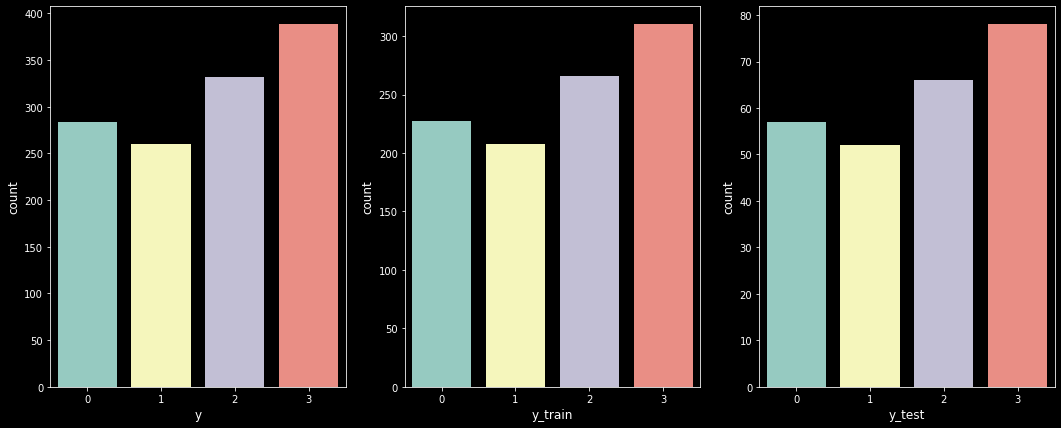

-------------------------------------------------------
X: (1264, 224, 224, 3)	X_train_processed:(1011, 224, 224, 3)	X_test_processed:(253, 224, 224, 3)
y: (1264,)		y_train_processed:(1011,)		y_test_processed:(253,)
-------------------------------------------------------


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
if len(X_train.shape) - 3:
    X_train_processed, y_train_processed, X_test_processed, y_test_processed = X_train.astype("float32") / 255.0, y_train, X_test.astype("float32") / 255.0, y_test
else:
    X_train_processed, y_train_processed, X_test_processed, y_test_processed = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1) / 255.0, y_train, X_test.reshape(-1, X_test.shape[1], X_test.shape[2], 1) / 255.0, y_test
fig, ax = plt.subplots(nrows=1, ncols=3)
sns.countplot(y, ax=ax[0]).set_xlabel("y")
sns.countplot(y_train, ax=ax[1]).set_xlabel("y_train")
sns.countplot(y_test, ax=ax[2]).set_xlabel("y_test")
plt.show()
print("-------------------------------------------------------")
print(f"X: {X.shape}\tX_train_processed:{X_train_processed.shape}\tX_test_processed:{X_test_processed.shape}")
print(f"y: {y.shape}\t\ty_train_processed:{y_train_processed.shape}\t\ty_test_processed:{y_test_processed.shape}")
print("-------------------------------------------------------")

# Building, Hyper-param Tuning CNN Model

In [6]:
def show_image(X, y, labels, model=None):
    _, ax = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
    for rows in ax:
        for col in rows:
            i = np.random.randint(0, len(X))
            col.axis("off")
            col.imshow(X[i], interpolation="none")
            col.set_title(f"{labels.get(y[i])}\n{labels.get(np.argmax(model.predict(X[i][np.newaxis, ...])[0]))} ({int(np.max(model.predict(X[i][np.newaxis, ...])[0]) * 100)}%)" if model else f"{labels.get(y[i])}")
    plt.show()


def tune_dl_model(hp):
    model = keras.models.Sequential()
    if PRETRAINED:
        model.add(hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", input_shape=X_train_processed.shape[1:], trainable=False))
    else:
        model.add(keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=X_train_processed.shape[1:]))
        model.add(keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2))
        model.add(keras.layers.experimental.preprocessing.RandomHeight(0.1))
        model.add(keras.layers.experimental.preprocessing.RandomWidth(0.1))
        model.add(keras.layers.experimental.preprocessing.RandomZoom(0.25))
        model.add(keras.layers.experimental.preprocessing.RandomRotation(0.2))
        model.add(keras.layers.experimental.preprocessing.RandomContrast(0.5))
        model.add(keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE))
        for i in range(hp.Int("num_layers", min_value=1, max_value=3, step=1)):
            model.add(keras.layers.Conv2D(filters=hp.Int(f"conv_{i:02}_filter", min_value=32, max_value=128, step=16), kernel_size=hp.Choice(f"conv_{i:02}_kernel", values=[3, 5]), activation="relu", padding="same"))
            model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.MaxPooling2D(pool_size=hp.Choice("pool_size", values=[2])))
        model.add(keras.layers.Flatten()),
        for i in range(hp.Int("num_layers", min_value=1, max_value=3, step=1)):
            model.add(keras.layers.Dense(units=hp.Int(f"dense_{i:02}_unit", min_value=32, max_value=128, step=16), activation="relu"))
            model.add(keras.layers.Dropout(hp.Float("dropout", min_value=0, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(units=len(set(y_train)), activation="softmax"))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3])
        ),
        loss="sparse_categorical_crossentropy",
        metrics="accuracy",
    )
    return model


def train_dl_model():
    tuner.search(
        X_train_processed,
        y_train_processed,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        epochs=MAX_TRIALS,
        validation_split=0.2,
        verbose=1,
    )
    tuner.results_summary()

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(
        X_train_processed,
        y_train_processed,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.2,
        verbose=1,
    )
    val_per_epoch = history.history["val_accuracy"]
    best_epoch = val_per_epoch.index(max(val_per_epoch)) + 1

    plt.subplot(1, 2, 1)
    sns.lineplot(data=history.history["accuracy"], color="deeppink", linewidth=2.5)
    sns.lineplot(data=history.history["val_accuracy"], color="darkturquoise", linewidth=2.5)
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Training Accuracy", "Val Accuracy"], loc="lower right")
    plt.grid()

    plt.subplot(1, 2, 2)
    sns.lineplot(data=history.history["loss"], color="deeppink", linewidth=2.5)
    sns.lineplot(data=history.history["val_loss"], color="darkturquoise", linewidth=2.5)
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Training Loss", "Val Loss"], loc="upper right")
    plt.grid()
    plt.show()
    print(f"Best epoch: {best_epoch}")
    
    return best_epoch, best_hps


def build_dl_model(best_epoch, best_hps):
    model = tuner.hypermodel.build(best_hps)
    model.fit(
        X_train_processed,
        y_train_processed,
        batch_size=BATCH_SIZE,
        epochs=best_epoch,
        validation_split=0.2,
        verbose=1,
    )
    classification_report_test = classification_report(
        y_test_processed,
        np.argmax(model.predict(X_test_processed), axis=1),
        output_dict=True,
    )
    print(f"accuracy: {classification_report_test['accuracy']:.3f} recall_macro: {classification_report_test['macro avg']['recall']:.3f} precision_macro: {classification_report_test['macro avg']['precision']:.3f} f1_macro: {classification_report_test['macro avg']['f1-score']:.3f} (Test)")
    classification_report_train = classification_report(
        y_train_processed,
        np.argmax(model.predict(X_train_processed), axis=1),
        output_dict=True,
    )
    print(f"accuracy: {classification_report_train['accuracy']:.3f} recall_macro: {classification_report_train['macro avg']['recall']:.3f} precision_macro: {classification_report_train['macro avg']['precision']:.3f} f1_macro: {classification_report_train['macro avg']['f1-score']:.3f} (Train)")
    print("-------------------------------------------------------")
    print(classification_report(y_test_processed, np.argmax(model.predict(X_test_processed), axis=1)))
    sns.heatmap(
        tf.math.confusion_matrix(y_test_processed, np.argmax(model.predict(X_test_processed), axis=1)),
        cmap="Blues",
        fmt="d",
        annot=True,
        linewidths=1,
    )
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    return model


if SEARCH == "hyperband":
    tuner = Hyperband(
        tune_dl_model,
        objective="val_accuracy",
        max_epochs=MAX_TRIALS,
        factor=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
elif SEARCH == "random":
    tuner = RandomSearch(
        tune_dl_model,
        objective="val_accuracy",
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
else:
    tuner = BayesianOptimization(
        tune_dl_model,
        objective="val_accuracy",
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=int(MAX_TRIALS/4))
tuner.search_space_summary()

2023-01-14 22:04:55.293838: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Search space summary
Default search space size: 1
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}


# Displaying Sample Images before the Training

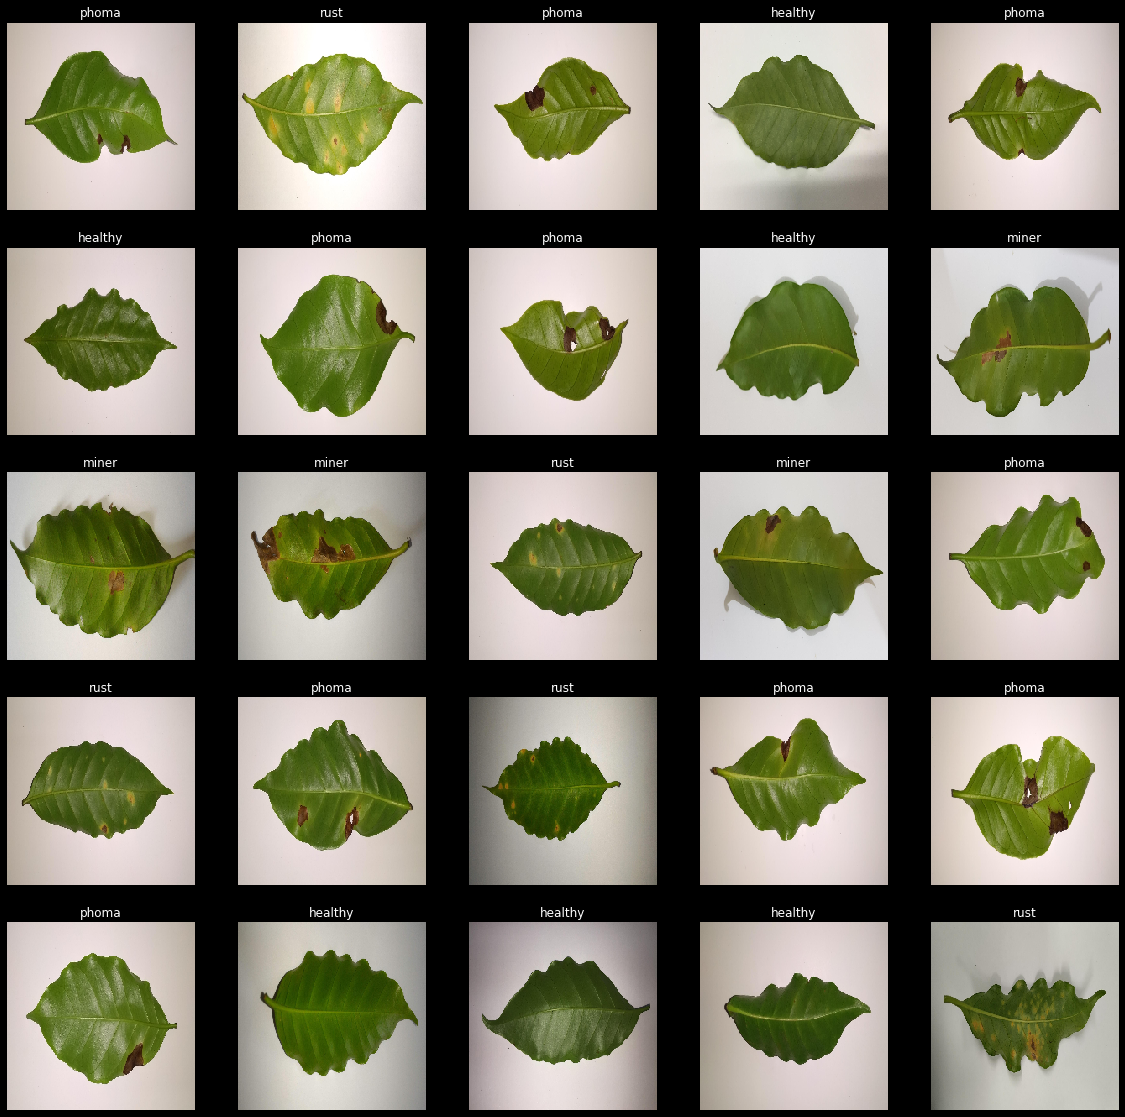

In [7]:
show_image(X, y, labels)

# Building Convolutional Neural Network Model

Trial 2 Complete [00h 00m 35s]
val_accuracy: 0.8226600885391235

Best val_accuracy So Far: 0.8916256427764893
Total elapsed time: 00h 01m 22s
Results summary
Results in ./keras_tuner
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.01
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.8916256427764893
Trial summary
Hyperparameters:
learning_rate: 0.001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.8226600885391235
Epoch 1/50
13/13 [==============================] - 14s 793ms/step - loss: 2.0589 - accuracy: 0.4839 - val_loss: 1.0626 - val_accuracy: 0.6552
Epoch 2/50
13/13 [==============================] - 10s 778ms/step - loss: 0.5788 - accuracy: 0.7896 - val_loss: 0.4027 - val_accuracy: 0.8473
Epoch 3/50
13/13 [==============================] - 9s 703ms/step - loss: 0.2939 - accuracy: 0.8936 - val_loss: 0.2827 - val_accuracy: 0.8818
Epoch 4/50
13/13 [==============================] - 9s 706ms/step - l

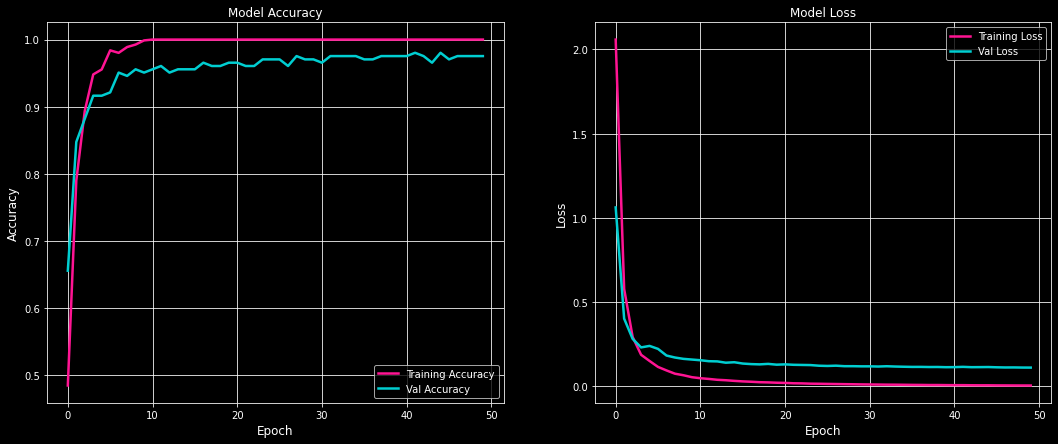

Best epoch: 42
Epoch 1/42
13/13 [==============================] - 14s 805ms/step - loss: 2.2263 - accuracy: 0.4356 - val_loss: 0.9788 - val_accuracy: 0.6404
Epoch 2/42
13/13 [==============================] - 10s 789ms/step - loss: 0.6377 - accuracy: 0.7636 - val_loss: 0.4265 - val_accuracy: 0.8227
Epoch 3/42
13/13 [==============================] - 9s 725ms/step - loss: 0.3165 - accuracy: 0.8861 - val_loss: 0.3039 - val_accuracy: 0.8621
Epoch 4/42
13/13 [==============================] - 9s 728ms/step - loss: 0.1861 - accuracy: 0.9332 - val_loss: 0.2355 - val_accuracy: 0.9360
Epoch 5/42
13/13 [==============================] - 10s 786ms/step - loss: 0.1426 - accuracy: 0.9579 - val_loss: 0.2183 - val_accuracy: 0.9360
Epoch 6/42
13/13 [==============================] - 9s 729ms/step - loss: 0.1196 - accuracy: 0.9691 - val_loss: 0.2285 - val_accuracy: 0.9163
Epoch 7/42
13/13 [==============================] - 9s 738ms/step - loss: 0.1054 - accuracy: 0.9752 - val_loss: 0.1907 - val_accur

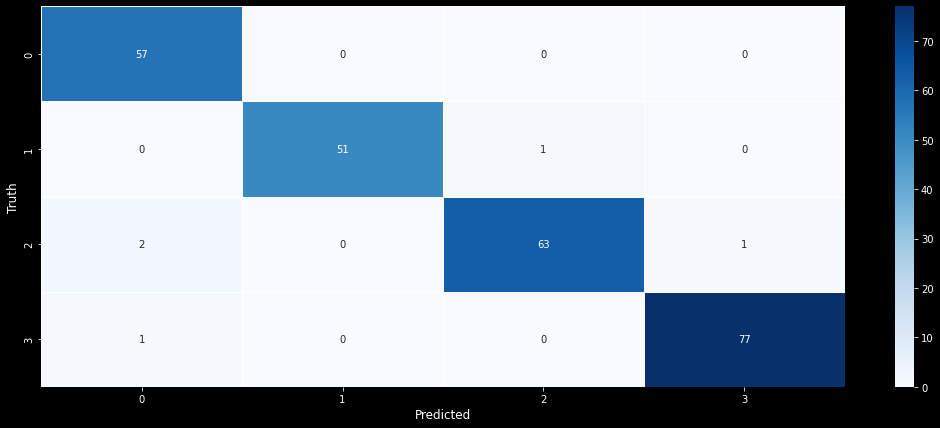

In [8]:
model = build_dl_model(*train_dl_model())

# Evaluating the Model

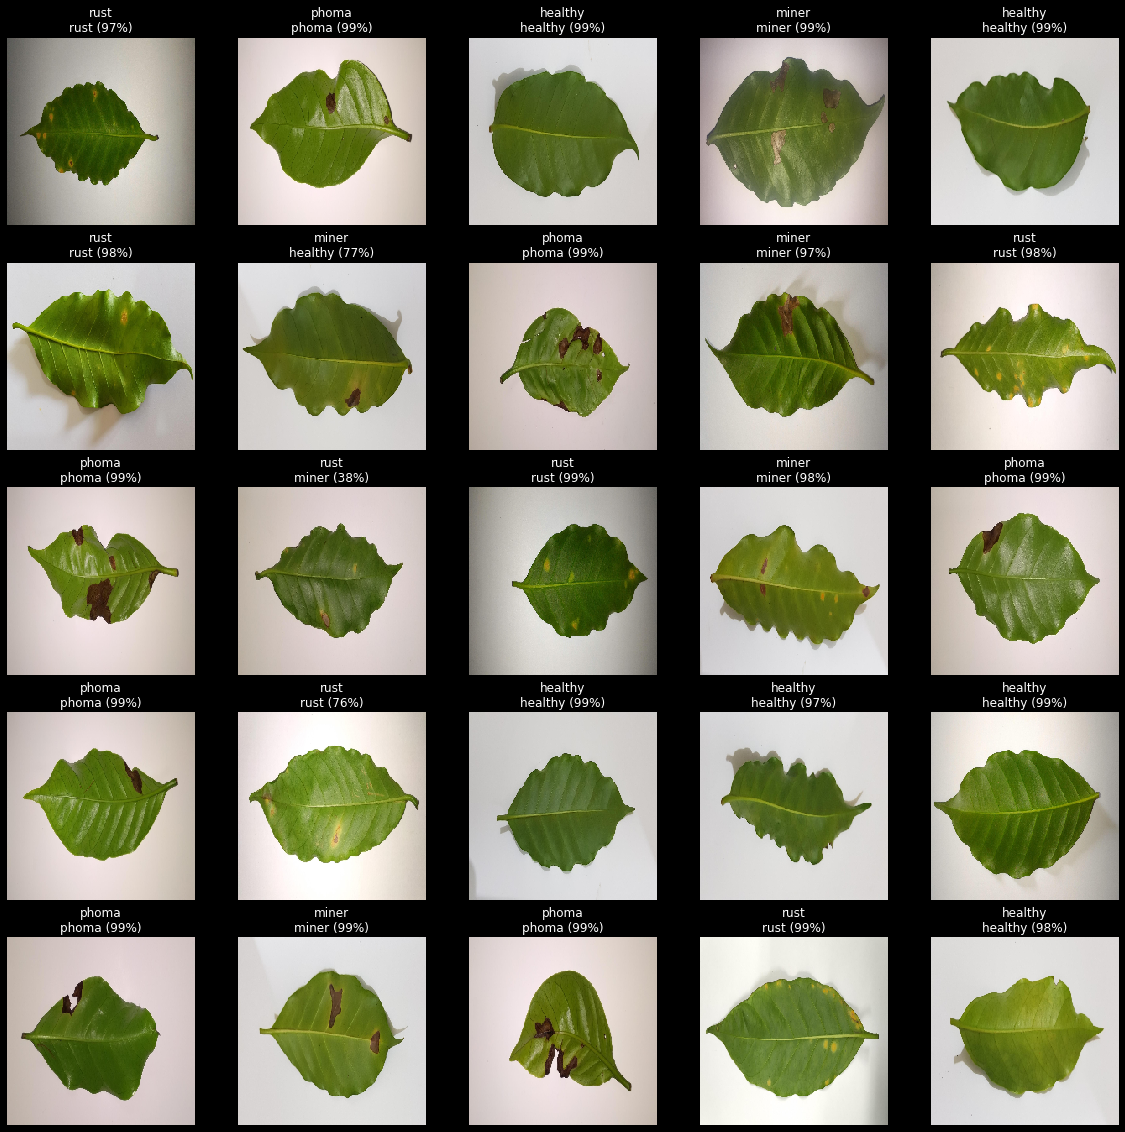

In [9]:
show_image(X_test_processed, y_test_processed, labels, model)

# Saving the Model for Deployment

2023-01-14 22:27:11.841045: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


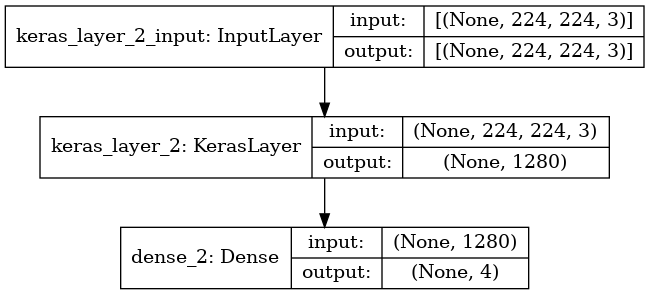

In [14]:
model.save(f"dl_model_{time_stamp}")
shutil.make_archive(f"dl_model_{time_stamp}", "zip", f"./dl_model_{time_stamp}")
model.summary()
plot_model(model, show_shapes=True)